In [1]:
import numpy
import keras
from keras.models import Model
from keras.layers import Activation
from keras.layers.core import Dense, Dropout, Flatten
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
from keras.layers import Input
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
import os

Using TensorFlow backend.


In [2]:
root_path = r"c:\Temp\181101_Spine"

train_path = os.path.join(root_path, "train")
valid_path = os.path.join(root_path, "valid")
test_path = os.path.join(root_path, "test")

In [3]:
image_size = 32
train_batch_size = 100

In [4]:
train_batches = ImageDataGenerator(rescale=1./255).flow_from_directory(
    train_path,
    target_size=(image_size, image_size),
    color_mode='grayscale',
    classes=["pos", "neg"],
    shuffle=True,
    batch_size=train_batch_size)

valid_batches = ImageDataGenerator(rescale=1./255).flow_from_directory(
    valid_path,
    target_size=(image_size, image_size),
    color_mode='grayscale',
    classes=["pos", "neg"],
    shuffle=True,
    batch_size=train_batch_size)

test_batches = ImageDataGenerator(rescale=1./255).flow_from_directory(
    test_path,
    target_size=(image_size, image_size),
    color_mode='grayscale',
    classes=["pos", "neg"],
    shuffle=True)

Found 2037 images belonging to 2 classes.
Found 715 images belonging to 2 classes.
Found 747 images belonging to 2 classes.


In [5]:
#Create train, validation, and test batches
train_batches.batch_size = train_batches.n
x_train, y_train = next(train_batches)

valid_batches.batch_size = valid_batches.n
x_valid, y_valid = next(valid_batches)

test_batches.batch_size = test_batches.n
x_test, y_test = next(test_batches)

In [6]:
print("x_test.shape: {}".format(x_test.shape))
print("y_test.shape: {}".format(y_test.shape))

print("x_valid.shape: {}".format(x_valid.shape))
print("y_valid.shape: {}".format(y_valid.shape))

print("x_train.shape: {}".format(x_train.shape))
print("y_train.shape: {}".format(y_train.shape))

x_test.shape: (747, 32, 32, 1)
y_test.shape: (747, 2)
x_valid.shape: (715, 32, 32, 1)
y_valid.shape: (715, 2)
x_train.shape: (2037, 32, 32, 1)
y_train.shape: (2037, 2)


In [7]:
input_img = Input(shape = (32, 32, 1))

In [8]:
#Build the layers - based on GoogLeNet
def inception(input_img):
    layera = Conv2D(64,(7,7),strides=(2,2),padding='same',activation='relu')(input_img)
    layerb = MaxPooling2D(pool_size=(2, 2))(layera)
    layerc = Conv2D(64,(1,1),padding ='same',activation='relu')(layerb)
    layerd = Conv2D(192,(3,3),padding='same',activation='relu')(layerc)
    layere = MaxPooling2D(pool_size=(3,3))(layerd)
    tower_1 = Conv2D(96, (1,1), padding='same', activation='relu')(layere)
    tower_1 = Conv2D(128, (3,3), padding='same', activation='relu')(tower_1)
    tower_2 = Conv2D(16, (1,1), padding='same', activation='relu')(layere)
    tower_2 = Conv2D(32, (5,5), padding='same', activation='relu')(tower_2)
    tower_3 = MaxPooling2D((3,3), strides=(1,1), padding='same')(layere)
    tower_3 = Conv2D(32, (1,1), padding='same', activation='relu')(tower_3)

    output = keras.layers.concatenate([tower_1, tower_2, tower_3], axis = 3) 
    return output

In [9]:
#Create the model
def inceptionModel():

    inputs = Input(shape = (32, 32, 1))

    x = inception(inputs)
    x_flat = Flatten()(x)
    x_drop = Dropout(0.4)(x_flat)
    x_dense = Dense(64, activation='relu')(x_drop)
    predictions = Dense(2, activation='softmax')(x_dense)

    model = Model(inputs=inputs, outputs=predictions)

    model.compile(loss=keras.losses.categorical_crossentropy,
                 optimizer=Adam(lr=0.001),
                 metrics=['accuracy'])
    return model

In [10]:
def plots(ims, figsize=(20,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis("Off")
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i][:, :, 0], cmap='gray')

In [11]:
modelA = inceptionModel()

modelA.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 32, 32, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 16, 16, 64)   3200        input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 8, 8, 64)     0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 8, 8, 64)     4160        max_pooling2d_1[0][0]            
__________________________________________________________________________________________________
conv2d_3 (

In [12]:
history = modelA.fit(x_train, y_train, epochs=20, shuffle=True,  validation_split=0.0, validation_data=(x_valid, y_valid))

Train on 2037 samples, validate on 715 samples
Epoch 1/20
2037/2037 [==============================] - 4s 2ms/step - loss: 0.5344 - acc: 0.7202 - val_loss: 0.7630 - val_acc: 0.7357
Epoch 2/20
2037/2037 [==============================] - 0s 181us/step - loss: 0.2681 - acc: 0.9018 - val_loss: 0.4672 - val_acc: 0.7888
Epoch 3/20
2037/2037 [==============================] - 0s 172us/step - loss: 0.1674 - acc: 0.9391 - val_loss: 0.6150 - val_acc: 0.8084
Epoch 4/20
2037/2037 [==============================] - 0s 177us/step - loss: 0.0807 - acc: 0.9676 - val_loss: 0.8666 - val_acc: 0.7664
Epoch 5/20
2037/2037 [==============================] - 0s 180us/step - loss: 0.0974 - acc: 0.9627 - val_loss: 0.5003 - val_acc: 0.7902
Epoch 6/20
2037/2037 [==============================] - 0s 178us/step - loss: 0.0777 - acc: 0.9686 - val_loss: 0.7087 - val_acc: 0.7916
Epoch 7/20
2037/2037 [==============================] - 0s 174us/step - loss: 0.0469 - acc: 0.9823 - val_loss: 0.9316 - val_acc: 0.7608
Epo

Text(0.5,1,'Accuracy Curves')

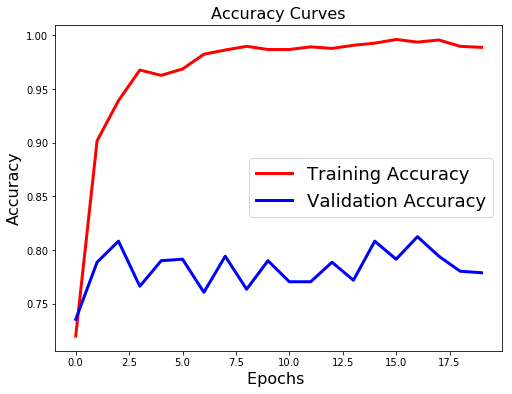

In [13]:
plt.figure(figsize=[8,6])
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [14]:
score = modelA.evaluate(x_test, y_test, verbose=0)
score[1]

0.7871485947764701

In [15]:
def predict_classes(self, x, batch_size=32, verbose=1):
    '''Generate class predictions for the input samples
    batch by batch.
    # Arguments
        x: input data, as a Numpy array or list of Numpy arrays
            (if the model has multiple inputs).
        batch_size: integer.
        verbose: verbosity mode, 0 or 1.
    # Returns
        A numpy array of class predictions.
    '''
    proba = self.predict(x, batch_size=batch_size, verbose=verbose)
    if proba.shape[-1] > 1:
        return proba.argmax(axis=-1)
    else:
        return (proba > 0.5).astype('int32')

In [16]:
y_pred = predict_classes(modelA, x_test)
acc = sum([y_test[i,1]==y_pred[i] for i in range(test_batches.n)]) / test_batches.n
print("Accuracy = {:.2f}%".format(acc))

747/747 [==============================] - 0s 106us/step
Accuracy = 0.79%


[1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1 0 1 1 0 1 1 0]
[0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 0 1 0 0 0 1 1 0 1 1 0 1 1 1]


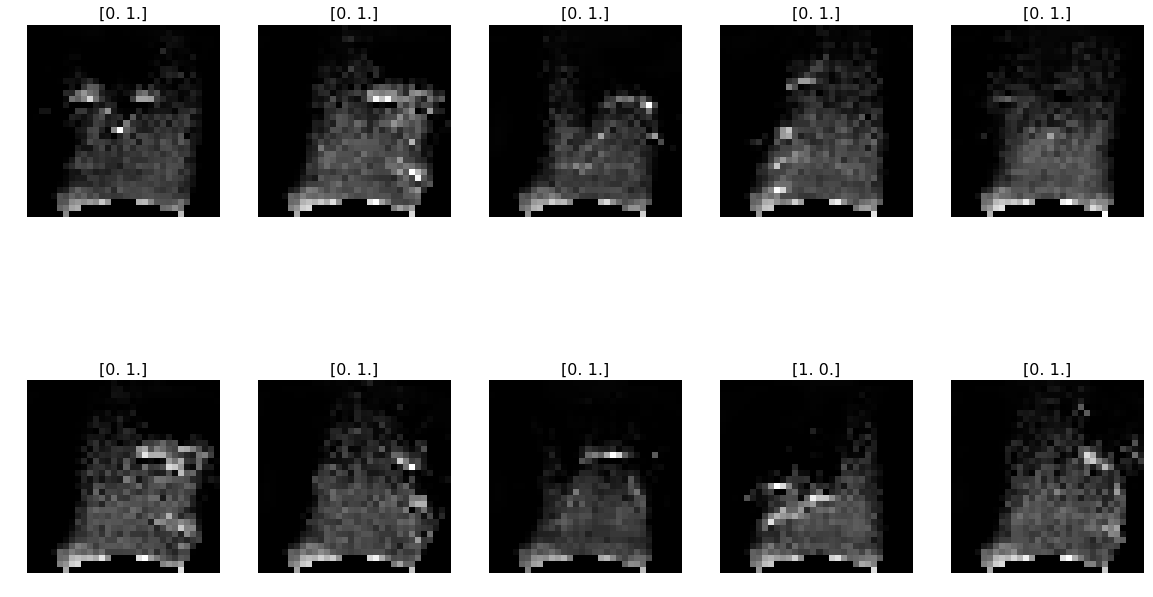

In [19]:
print(y_test[:30,1].astype(int))
print(y_pred[:30])
plots(x_test[:10], titles=y_test[:10], figsize=(20,12), rows=2)

In [18]:
import pandas as pd
y_t = pd.Series(y_test[:,1])
y_p = pd.Series(y_pred)
pd.crosstab(y_t, y_p, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
True,,,
0.0,219,74,293
1.0,85,369,454
All,304,443,747
